In [75]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import describe


In [74]:
def create_dataset(X, y):
    Xs, ys = [], []
    for i in range(len(X) - 1):
        Xs.append(X.iat[i])        
        ys.append(y.iat[i + 1])
    return np.array(Xs), np.array(ys)

def reject_outliers(data, m=2):
    t1 = abs(data - np.mean(data)) < m * np.std(data)
    return data[(np.where(t1 == True))[0]]

In [45]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [66]:
#read data
data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
data = data.dropna()
data = data.reset_index(drop=True)

In [145]:
K = 10
data_per_fold = 20000
train_percent = 0.70

for fold_no in range(K):
    fold_start_index = np.random.randint(0, len(data) - data_per_fold)
    fold_end_index = fold_start_index + data_per_fold
    
    fold_data = data[fold_start_index : fold_end_index]
    fold_train_end_index = int(train_percent * fold_data.__len__())
    fold_train_data = fold_data[0 : fold_train_end_index]
    fold_test_data = fold_data[fold_train_end_index : ]
    
    # extact no meal data for train data
    train_data = fold_train_data.loc[(fold_train_data['meal_start'] == 0) & (fold_train_data['meal'] == 0)]['cgm']
    # include both meal and no meal for test data
    test_data = fold_test_data['cgm']
    
    X_train, y_train = create_dataset(train_data, train_data)
    X_test, y_test = create_dataset(test_data, test_data)
    
    X_train= X_train.reshape(len(X_train), 1, 1)
    X_test = X_test.reshape(len(X_test), 1, 1)
    
    model_cgm = keras.Sequential()
    model_cgm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]))) # batch_size * time_steps * num_features
    model_cgm.add(keras.layers.Dense(1))
    model_cgm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
    
    fitted_model_cgm = model_cgm.fit(
        X_train, y_train, 
        epochs=150, 
        batch_size=32, 
        validation_split=0.1, 
        verbose=0, 
        shuffle=False
    )
    
    y_pred = model_cgm.predict(X_test)
    
    # compute meal and no-meal differences here

    meal_diff = []
    non_meal_diff = []
    meal_truth = (fold_test_data['meal_start'] == 1).to_numpy()
    meal_indices = np.where(meal_truth == True)[0]
    non_meal_indices = np.where(meal_truth == False)[0]

    for idx in meal_indices:
        if idx < len(y_test):
            meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))

    for idx in non_meal_indices:
        if idx < len(y_test):
            non_meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))
    
    meal_diff = np.array(meal_diff)
    non_meal_diff = np.array(non_meal_diff)
    
    print("#" * 10)
    threshold = 5.5
    non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
    meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]
    
    true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
    true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()
    
    false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
    false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()
    
    print("TP ", true_positive, "FP ", false_positive, "TN ", true_negative, "FN ", false_negative)
    print("accuracy: ", (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )
    print("#" * 10)

##########
TP  0.32673267326732675 FP  0.3236690403526619 TN  0.676330959647338 FN  0.6732673267326733
accuracy:  0.6704450741790299
##########
##########
TP  0.3643410852713178 FP  0.3275979557069847 TN  0.6724020442930153 FN  0.6356589147286822
accuracy:  0.6657776296049341
##########
##########
TP  0.3069306930693069 FP  0.2984062394031875 TN  0.7015937605968124 FN  0.693069306930693
accuracy:  0.6949491581930322
##########
##########
TP  0.44545454545454544 FP  0.4155204618780778 TN  0.5844795381219222 FN  0.5545454545454546
accuracy:  0.5819303217202867
##########
##########
TP  0.5588235294117647 FP  0.5501102255384094 TN  0.4498897744615906 FN  0.4411764705882353
accuracy:  0.45174195699283215
##########
##########
TP  0.30357142857142855 FP  0.2787497876677425 TN  0.7212502123322575 FN  0.6964285714285714
accuracy:  0.7134522420403401
##########
##########
TP  0.3925233644859813 FP  0.44161575016972165 TN  0.5583842498302783 FN  0.6074766355140186
accuracy:  0.5554259043173863


In [132]:
all_meal_diff = np.array(all_meal_diff)
all_no_meal_diff = np.array(all_no_meal_diff)

all_no_meal_diff = reject_outliers(all_no_meal_diff)
all_no_meal_diff = np.random.choice(all_no_meal_diff, 1500, replace=False)

ValueError: Cannot take a larger sample than population when 'replace=False'

##########
TP  0.4024691358024691 FP  0.26264880952380953 TN  0.7373511904761905 FN  0.5975308641975309
accuracy:  0.6598056032018296
##########


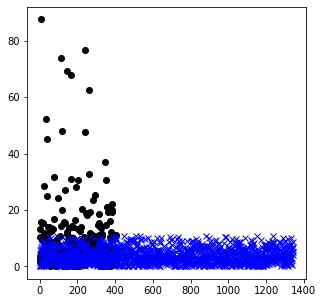

In [143]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(all_meal_diff, 'o', color='black')
plt.plot(all_no_meal_diff, 'x', color='blue')
plt.hlines(3.0, 0, 1000, color='black')

meal_diff = all_meal_diff
non_meal_diff = all_no_meal_diff

print("#" * 10)
threshold = 5.5
non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]

true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()

false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()

print("TP ", true_positive, "FP ", false_positive, "TN ", true_negative, "FN ", false_negative)
print("accuracy: ", (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )
print("#" * 10)

In [124]:
y_pred = model_cgm.predict(X_test)
    
# compute meal and no-meal differences here

meal_diff = []
non_meal_diff = []
meal_truth = (fold_test_data['meal_start'] == 1).to_numpy()
meal_indices = np.where(meal_truth == True)[0]
non_meal_indices = np.where(meal_truth == False)[0]

for idx in meal_indices:
    if idx < len(y_test):
        meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))

for idx in non_meal_indices:
    if idx < len(y_test):
        non_meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))

meal_diff = np.array(meal_diff)
non_meal_diff = np.array(non_meal_diff)

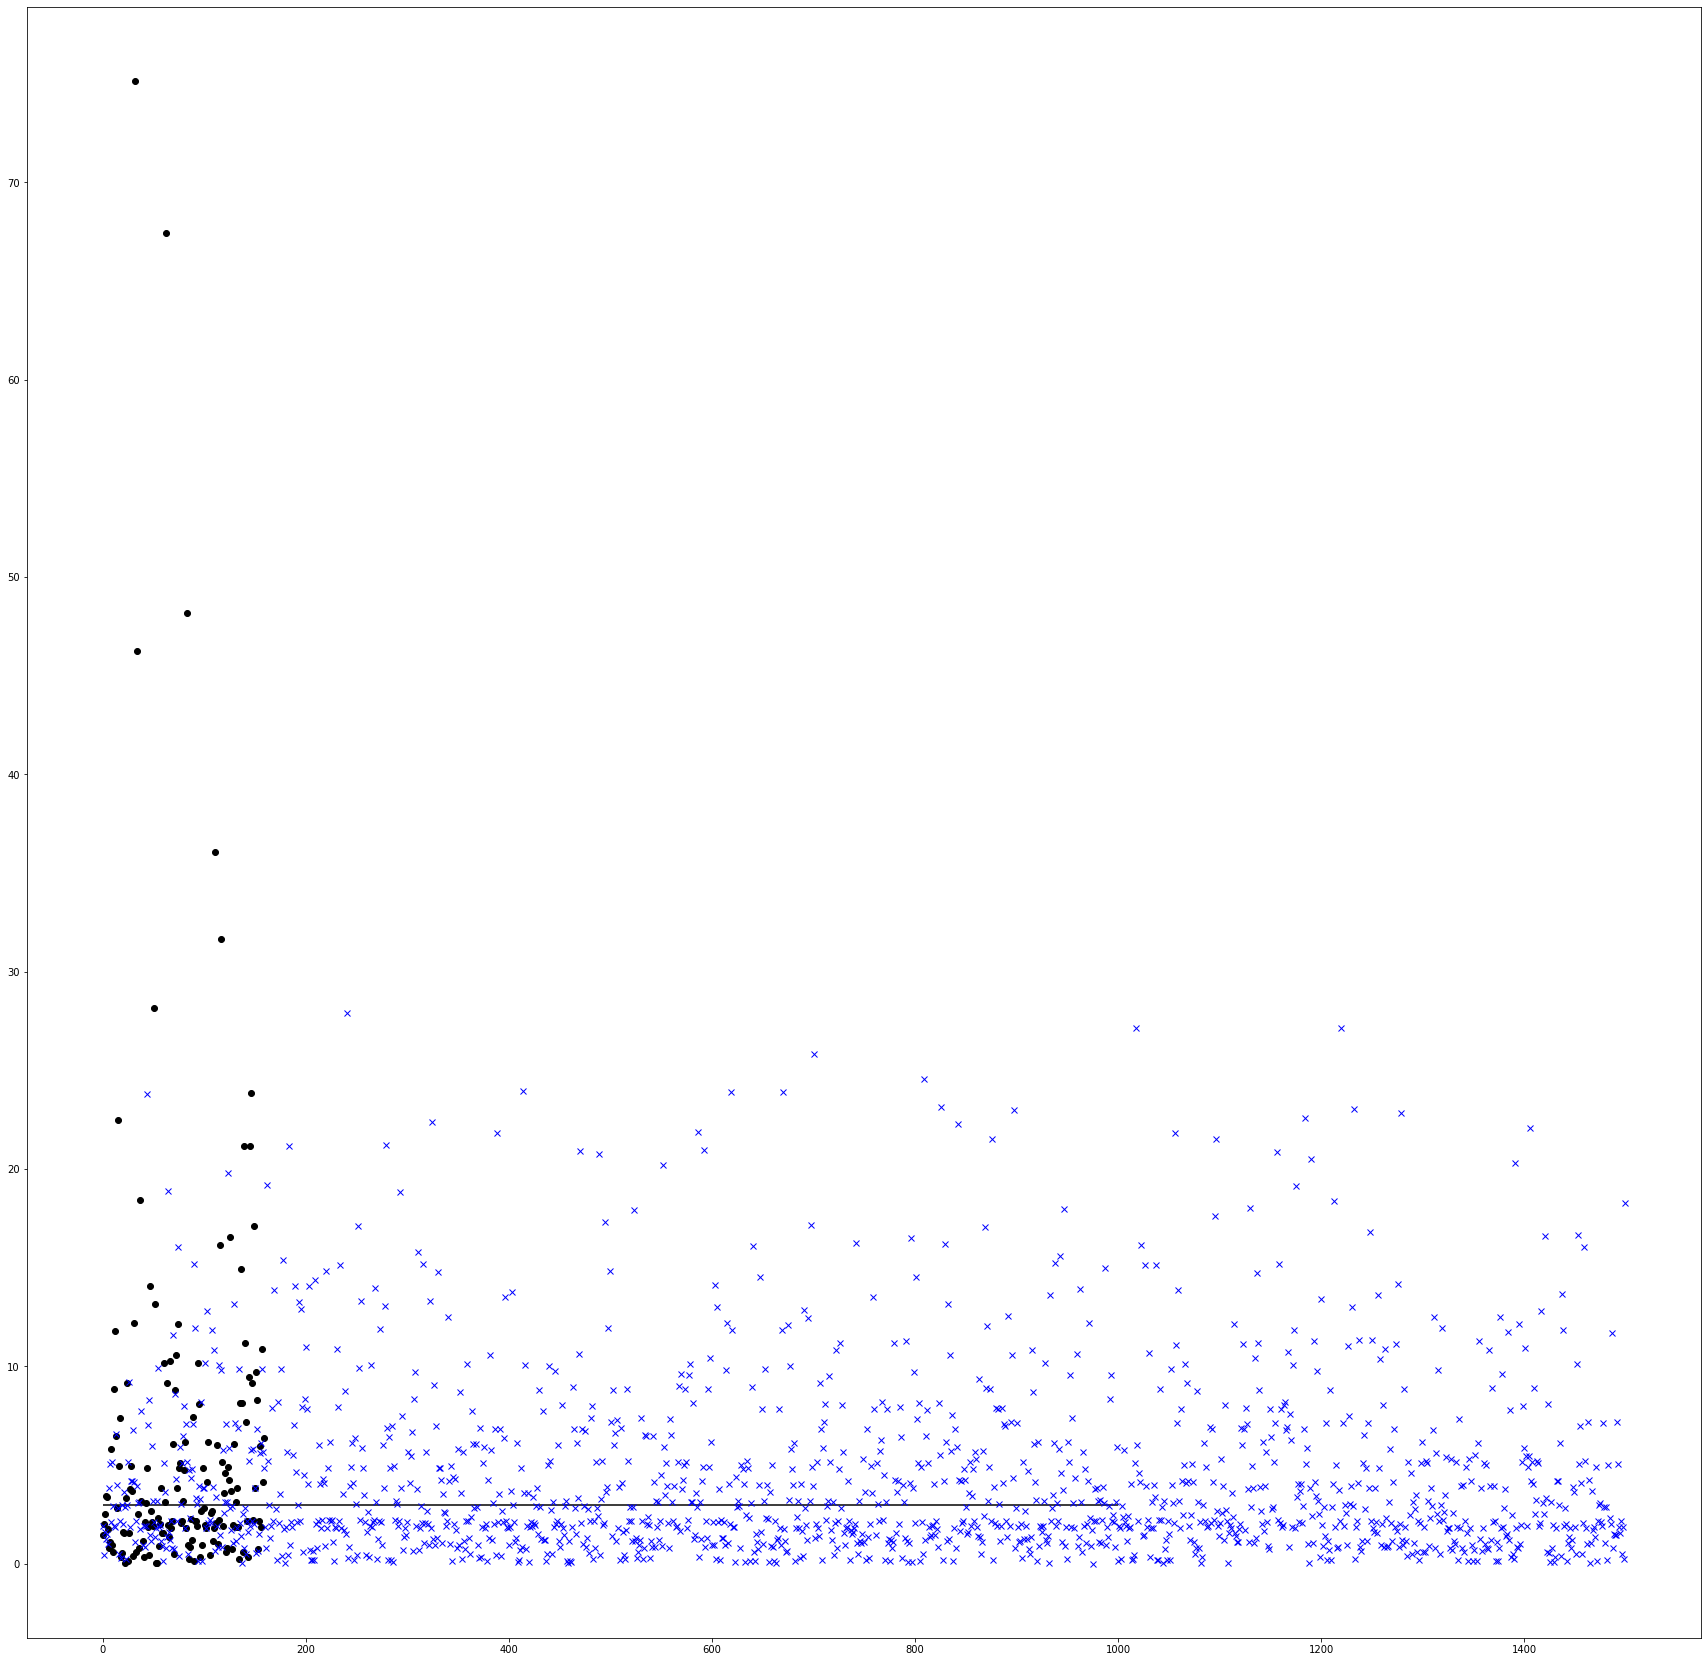

In [125]:
non_meal_diff = reject_outliers(non_meal_diff)
non_meal_diff = np.random.choice(non_meal_diff, 1500, replace=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.plot(meal_diff, 'o', color='black')
plt.plot(non_meal_diff, 'x', color='blue')
plt.hlines(3.0, 0, 1000, color='black')

In [95]:
len(fold_train_data)

21000

In [105]:
fold_test_data

,cgm,time_insulin,time_cgm,meal_start,meal
21466,85.0,2017-11-12 23:57:02,2017-11-12 23:59:54,0,0
21467,81.0,2017-11-13 00:00:00,2017-11-13 00:04:54,0,0
21468,76.0,2017-11-13 00:07:02,2017-11-13 00:09:54,0,0
21469,59.0,2017-11-13 00:15:33,2017-11-13 00:19:53,0,0
21470,59.0,2017-11-13 00:15:36,2017-11-13 00:19:53,0,0
...,...,...,...,...,...
30461,197.0,2017-12-28 05:05:38,2017-12-28 05:10:20,0,0
30462,206.0,2017-12-28 05:10:33,2017-12-28 05:15:20,0,0
30463,218.0,2017-12-28 05:15:31,2017-12-28 05:20:20,0,0
30464,232.0,2017-12-28 05:20:33,2017-12-28 05:25:20,0,0


21466    False
21467    False
21468    False
21469    False
21470    False
         ...  
30461    False
30462    False
30463    False
30464    False
30465    False
Name: meal_start, Length: 9000, dtype: bool

In [108]:
fold_test_data[fold_test_data['meal_start'] == 1]

,cgm,time_insulin,time_cgm,meal_start,meal
21496,254.0,2017-11-13 02:55:07,2017-11-13 02:59:53,1,0
21547,142.0,2017-11-13 09:18:15,2017-11-13 09:19:55,1,0
21588,117.0,2017-11-13 16:00:00,2017-11-13 16:00:21,1,0
21663,131.0,2017-11-13 23:35:33,2017-11-13 23:40:22,1,0
21693,118.0,2017-11-14 04:20:32,2017-11-14 04:25:24,1,0
...,...,...,...,...,...
30123,140.0,2017-12-26 08:41:33,2017-12-26 08:46:14,1,0
30284,188.0,2017-12-27 01:51:22,2017-12-27 01:56:18,1,0
30333,188.0,2017-12-27 05:46:24,2017-12-27 05:51:18,1,0
30368,193.0,2017-12-27 08:06:29,2017-12-27 08:11:20,1,0
